In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import accuracy_score

# For reproducibility purpose
torch.manual_seed(99)
torch.use_deterministic_algorithms(True)

# 1. Loading the dataset

### a. Initial data importing and spliting 

In [2]:
diabetes_full_df = pd.read_csv("diabetes.csv")

# Splitting the full dataset into training, validation and testing data with a 70:15:15 ratio
diabetes_train_df, diabetes_val_test_df = train_test_split(
    diabetes_full_df, train_size = 0.7, stratify = diabetes_full_df.Outcome, random_state = 93)

diabetes_val_df, diabetes_test_df = train_test_split(
    diabetes_val_test_df, train_size = 0.5, stratify = diabetes_val_test_df.Outcome, random_state = 96)

In [3]:
# Extracting the predictor variables
diabetes_features = [var for var in diabetes_train_df.columns if var != 'Outcome']

### b. Data Preprocessing

- Scaling the data to have mean of zero and standard deviation of 1

In [4]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler().set_output(transform = "pandas")

# Extracting the predictors
diabetes_features = [var for var in diabetes_train_df.columns if var != 'Outcome']

# Apply the Standard Scaler to the X (faetures) of the training data (not including the target variable 'Outcome')
diabetes_train_preprocessed_df = std_scaler.fit_transform(diabetes_train_df[diabetes_features])

# Put back the target variable 'Outcome' 
diabetes_train_preprocessed_df['Outcome'] = diabetes_train_df['Outcome']

In [5]:
# Synchronise the preprocessing step of scaling onto the validation data
diabetes_val_processed_df = std_scaler.transform(diabetes_val_df[diabetes_features])
diabetes_val_processed_df['Outcome'] = diabetes_val_df['Outcome'].astype('category')

# Synchronise the preprocessing step of scaling onto the testing data
diabetes_test_processed_df = std_scaler.transform(diabetes_test_df[diabetes_features])
diabetes_test_processed_df['Outcome'] = diabetes_test_df['Outcome'].astype('category')

- Oversampling the training data using SMOTE 

*(This preprocessing step is just to facilitate the training process, so it will not get inferred onto the validation and testing data)*

In [6]:
from imblearn.over_sampling import SMOTE

smote_spec = SMOTE(random_state = 95, k_neighbors = 5)

# Apply the SMOTE on the training data
diabetes_X_train_oversampled, diabetes_y_train_oversampled = smote_spec.fit_resample(
    X = diabetes_train_preprocessed_df[diabetes_features], y = diabetes_train_preprocessed_df['Outcome'])

# The SMOTE-oversampling output is a NumPy array, so update the preprocessed training data in a Pandas dataframe
diabetes_train_preprocessed_df = pd.DataFrame(diabetes_X_train_oversampled, columns = diabetes_features)
diabetes_train_preprocessed_df['Outcome'] = diabetes_y_train_oversampled.astype('category')
diabetes_train_preprocessed_df # It can be seen now that the training data has 700 instances 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.018881,-0.636730,-3.385990,-1.266133,-0.669042,-0.228058,0.043701,-0.072585,1
1,2.256052,-0.541433,-0.021468,1.286814,-0.669042,1.793098,-1.037973,0.789765,0
2,-0.836876,0.189173,-0.615207,0.584753,0.612248,-0.390249,1.001497,-1.021171,0
3,-0.527583,-0.414371,0.275401,0.648577,0.173912,0.221088,-0.198014,-0.848701,0
4,-0.836876,-0.033185,0.968097,1.350637,0.763980,1.680811,0.113194,-0.589995,0
...,...,...,...,...,...,...,...,...,...
695,-0.501630,1.764122,-0.004861,0.752346,0.642696,0.229377,-0.638878,-0.209473,1
696,2.171464,0.724015,0.553677,0.758235,0.431409,-0.535693,-0.578563,0.907686,1
697,4.068460,1.354957,0.188333,1.359583,0.312685,1.123612,1.060971,1.227847,1
698,1.051600,1.929450,1.093060,-1.266133,-0.669042,0.223603,-0.551986,2.319046,1


### c. Loading the datasets using Dataset and DataLoader

In [7]:
class DatasetObject(Dataset):
    def __init__(self, dataframe, target_var):
        self.data = dataframe
        self.target = target_var
        self.predictors = [var for var in self.data.columns if var != target_var]
        self.X = self.data[self.predictors]
        self.y = self.data[target_var]

    def __getitem__(self, index):
        if isinstance(index, torch.Tensor):
            index = index.tolist()

        return [self.X.iloc[index, :].values, self.y.values[index]]
    
    def __len__(self):
        return len(self.data)

In [8]:
diabetes_train_dataset = DatasetObject(diabetes_train_preprocessed_df, target_var = 'Outcome')
diabetes_val_dataset = DatasetObject(diabetes_val_processed_df, target_var = 'Outcome')
diabetes_test_dataset = DatasetObject(diabetes_test_processed_df, target_var = 'Outcome')

In [9]:
diabetes_train = DataLoader(diabetes_train_dataset, batch_size = 32, shuffle = False)
diabetes_val = DataLoader(diabetes_val_dataset, batch_size = 32, shuffle = False)
diabetes_test = DataLoader(diabetes_test_dataset, batch_size = 32, shuffle = False)

# 2. Preparing functions to train and evaluate models

In [10]:
def train_and_validate_model(model, criterion, optim, epochs, train_input, val_input, print_log: bool):

    training_log = pd.DataFrame({'epoch': [], 'training_loss' : [], 'training_accuracy': [],
                                 'validation_loss': [], 'validation_accuracy': []})
    for epoch in range(epochs):
        # Training the model on the training set
        total_train_loss = 0
        y_train_true, y_train_pred = [], []
        for X_train, y_train in train_input:
            model.train() # Set the model to training mode
            optim.zero_grad()
            X_train = X_train.to(torch.float32)
            outputs = model(X_train)
            _, predicted_class = torch.max(outputs, 1)

            y_train_true.extend(np.array(y_train))
            y_train_pred.extend(np.array(predicted_class))
            current_batch_train_loss = criterion(outputs, y_train) # The training_loss at the last epoch will be recorded
            total_train_loss += current_batch_train_loss.item()
            current_batch_train_loss.backward()
            optim.step()

        train_loss = total_train_loss / len(train_input) # Total accumulated loss divided by the number of batches
        train_accuracy = accuracy_score(y_true = y_train_true, y_pred = y_train_pred)

        # Evaluating on the validation set
        model.eval() # Set the model to evaluation mode
        total_val_loss = 0
        y_val_true, y_val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_input:
                X_val = X_val.to(torch.float32)
                outputs = model(X_val)
                current_batch_val_loss = criterion(outputs, y_val) # The val_loss at the last epoch will be recorded
                total_val_loss += current_batch_val_loss.item()
                _, predicted_class = torch.max(outputs, 1)
                y_val_true.extend(np.array(y_val))
                y_val_pred.extend(np.array(predicted_class))
        
        val_loss = total_val_loss / len(val_input) # Total accumulated loss divided by the number of batches
        val_accuracy = accuracy_score(y_true = y_val_true, y_pred = y_val_pred)
        
        if print_log == True:
            print('Epoch:', epoch+1, '| Training Loss:', round(train_loss, 3), '| Training Accuracy:', round(train_accuracy, 3), 
                  '| Validation Loss:', round(val_loss, 3), '| Validation Accuracy:', round(val_accuracy, 3), sep = " ")
            
        training_log.loc[len(training_log)] = [epoch, train_loss, train_accuracy, val_loss, val_accuracy]
    
    return training_log

# 3. Experimenting with the Single-layer perceptron (SLP) model

In [11]:
class MySLP(nn.Module):
    def __init__(self, input_size, no_of_output_classes):
        super(MySLP, self).__init__()
        self.layer_out = nn.Linear(input_size, no_of_output_classes)

    def forward(self, X_input):
        output = self.layer_out(X_input)
        return output
        

### a. Optimising some hyperparameters for the SLP model

In [15]:
slp_hyperparams_space = {'epochs': [50, 75, 100, 125, 150],
                         'lr': [0.0001, 0.0005, 0.001, 0.005, 0.01],
                         'optimiser': ['SGD', 'Adam', 'RMSprop']}

In [16]:
slp_hyperparams_tune_result = pd.DataFrame(
    {'max_epochs': [], 'learning_rate': [], 'optimiser': [], 'validation_accuracy': []})

for epochs in slp_hyperparams_space['epochs']:
    for lr in slp_hyperparams_space['lr']:
        for optimiser in slp_hyperparams_space['optimiser']:
            torch.manual_seed(99) # For reproducibility purpose
            my_model_1 = MySLP(8, 2)
            my_criterion_1 = nn.CrossEntropyLoss()

            if optimiser == 'SGD':
                my_optimizer_1 = optim.SGD(params = my_model_1.parameters(), lr = lr)
            if optimiser == 'Adam':
                my_optimizer_1 = optim.Adam(params = my_model_1.parameters(), lr = lr)
            if optimiser == 'RMSprop':
                my_optimizer_1 = optim.RMSprop(params = my_model_1.parameters(), lr = lr)

            training_log_df = train_and_validate_model(
                model = my_model_1, criterion = my_criterion_1, optim = my_optimizer_1, 
                epochs = epochs, train_input = diabetes_train, val_input = diabetes_val, print_log = False)
            
            val_accuracy = training_log_df['validation_accuracy'].values[-1]

            slp_hyperparams_tune_result.loc[len(slp_hyperparams_tune_result)] = [
                epochs, lr, optimiser, val_accuracy]

In [18]:
# Sorting the hyperparameter tuning results by the descending order of validation accuracy and the ascending of max_epochs
slp_hyperparams_tune_result.sort_values(["validation_accuracy", "max_epochs"], ascending = [False, True])

,max_epochs,learning_rate,optimiser,validation_accuracy
8,50,0.0010,RMSprop,0.713043
11,50,0.0050,RMSprop,0.713043
12,50,0.0100,SGD,0.713043
14,50,0.0100,RMSprop,0.713043
22,75,0.0010,Adam,0.713043
...,...,...,...,...
60,150,0.0001,SGD,0.582609
45,125,0.0001,SGD,0.547826
30,100,0.0001,SGD,0.539130
0,50,0.0001,SGD,0.530435


### b. Train a Single-Layer Perceptron model with the best hyperparameter values chosen from above and evaluate it on the validation data

In [25]:
# Train the best SLP model again for a closer inspection
torch.manual_seed(99) # For reproducibility purpose
my_slp_model = MySLP(8, 2)
my_criterion_1 = nn.CrossEntropyLoss()
my_optimizer_1 = optim.RMSprop(my_slp_model.parameters(), lr = 0.001)

my_slp_model_training_log = train_and_validate_model(
    model = my_slp_model, criterion = my_criterion_1, optim = my_optimizer_1, 
    epochs = 50, train_input = diabetes_train, val_input = diabetes_val, print_log = True)

Epoch: 1 | Training Loss: 0.72 | Training Accuracy: 0.587 | Validation Loss: 0.777 | Validation Accuracy: 0.6
Epoch: 2 | Training Loss: 0.665 | Training Accuracy: 0.64 | Validation Loss: 0.746 | Validation Accuracy: 0.626
Epoch: 3 | Training Loss: 0.638 | Training Accuracy: 0.661 | Validation Loss: 0.725 | Validation Accuracy: 0.635
Epoch: 4 | Training Loss: 0.62 | Training Accuracy: 0.677 | Validation Loss: 0.709 | Validation Accuracy: 0.661
Epoch: 5 | Training Loss: 0.605 | Training Accuracy: 0.691 | Validation Loss: 0.697 | Validation Accuracy: 0.652
Epoch: 6 | Training Loss: 0.593 | Training Accuracy: 0.699 | Validation Loss: 0.686 | Validation Accuracy: 0.661
Epoch: 7 | Training Loss: 0.584 | Training Accuracy: 0.703 | Validation Loss: 0.677 | Validation Accuracy: 0.687
Epoch: 8 | Training Loss: 0.575 | Training Accuracy: 0.711 | Validation Loss: 0.669 | Validation Accuracy: 0.678
Epoch: 9 | Training Loss: 0.568 | Training Accuracy: 0.717 | Validation Loss: 0.662 | Validation Accu

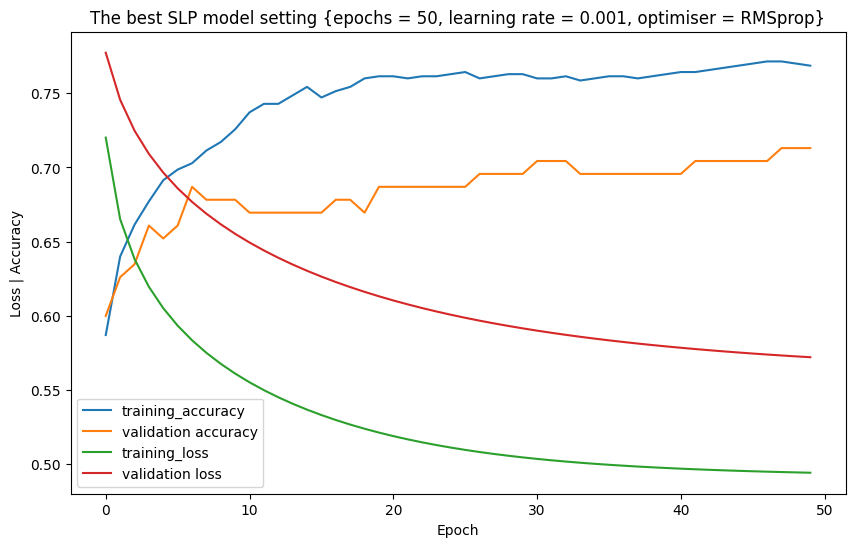

In [67]:
# Plotting the learning curves of the best SLP model
plt.figure(figsize = (10, 6))
plt.plot(my_slp_model_training_log['epoch'], my_slp_model_training_log['training_accuracy'], label = "training_accuracy")
plt.plot(my_slp_model_training_log['epoch'], my_slp_model_training_log['validation_accuracy'], label = "validation accuracy")
plt.plot(my_slp_model_training_log['epoch'], my_slp_model_training_log['training_loss'], label = "training_loss")
plt.plot(my_slp_model_training_log['epoch'], my_slp_model_training_log['validation_loss'], label = "validation loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss | Accuracy')
plt.title('The best SLP model setting {epochs = 50, learning rate = 0.001, optimiser = RMSprop}')
plt.show()

# 4. Multi-layer perceptron (MLP) models

In [14]:
class MyMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes: list, no_of_output_classes):
        super(MyMLP, self).__init__()
        self.input_size = input_size

        self.hidden = nn.ModuleList()
        for hidden_size, corresponding_act_fn in hidden_sizes:
            self.hidden.append(nn.Linear(self.input_size, hidden_size))
            if corresponding_act_fn is not None:
                self.hidden.append(corresponding_act_fn) # Assume that 'corresponding_act_fn' is input correctly (under the 'nn' class)
            self.input_size = hidden_size
        
        self.layer_out = nn.Linear(self.input_size, no_of_output_classes)

    def forward(self, X_input):
        for layer in self.hidden:
            X_input = layer(X_input)
        output = self.layer_out(X_input)
        return output

### a. Optimising some hyperparameters for the MLP model

Because it is desired that each hidden layer could have its own activation function instead of using a fixed one, the following list of 'hidden_sizes_space' will be created before optimising the MLP hyperparameters.

In [17]:
import itertools

# Creating a custom list of all possible combinations between the hidden sizes and the activation functions chosen
hidden_sizes_space = [16, 32, 64]
act_fn_space = [None, nn.ReLU(), nn.Tanh()]

hidden_sizes_with_act_fn = []

one_layer_list = list(itertools.combinations(list(itertools.product(hidden_sizes_space, act_fn_space)), r = 1))
for layer in one_layer_list:
    hidden_sizes_with_act_fn.append([layer[0]])

two_layers_list = list(itertools.combinations(list(itertools.product(hidden_sizes_space, act_fn_space)), r = 2))
for layer_1, layer_2 in two_layers_list: # Excluded if a layer has more nodes than its previous layer(s)
    if layer_1[0] < layer_2[0]:
        hidden_sizes_with_act_fn.append([layer_1, layer_2])

three_layers_list = list(itertools.combinations(list(itertools.product(hidden_sizes_space, act_fn_space)), r = 3))
for layer_1, layer_2, layer_3 in three_layers_list: # Excluded if a layer has more nodes than its previous layer(s)
    if layer_1[0] < layer_2[0] and layer_2[0] < layer_3[0]:
        hidden_sizes_with_act_fn.append([layer_1, layer_2, layer_3])

hidden_sizes_with_act_fn

[[(16, None)],
 [(16, ReLU())],
 [(16, Tanh())],
 [(32, None)],
 [(32, ReLU())],
 [(32, Tanh())],
 [(64, None)],
 [(64, ReLU())],
 [(64, Tanh())],
 [(16, None), (32, None)],
 [(16, None), (32, ReLU())],
 [(16, None), (32, Tanh())],
 [(16, None), (64, None)],
 [(16, None), (64, ReLU())],
 [(16, None), (64, Tanh())],
 [(16, ReLU()), (32, None)],
 [(16, ReLU()), (32, ReLU())],
 [(16, ReLU()), (32, Tanh())],
 [(16, ReLU()), (64, None)],
 [(16, ReLU()), (64, ReLU())],
 [(16, ReLU()), (64, Tanh())],
 [(16, Tanh()), (32, None)],
 [(16, Tanh()), (32, ReLU())],
 [(16, Tanh()), (32, Tanh())],
 [(16, Tanh()), (64, None)],
 [(16, Tanh()), (64, ReLU())],
 [(16, Tanh()), (64, Tanh())],
 [(32, None), (64, None)],
 [(32, None), (64, ReLU())],
 [(32, None), (64, Tanh())],
 [(32, ReLU()), (64, None)],
 [(32, ReLU()), (64, ReLU())],
 [(32, ReLU()), (64, Tanh())],
 [(32, Tanh()), (64, None)],
 [(32, Tanh()), (64, ReLU())],
 [(32, Tanh()), (64, Tanh())],
 [(16, None), (32, None), (64, None)],
 [(16, None),

In [18]:
mlp_hyperparams_space = {'epochs': [50, 75, 100, 125, 150],
                     'hidden_sizes': hidden_sizes_with_act_fn,
                     'lr': [0.0001, 0.0005, 0.001, 0.005, 0.01],
                     'optimiser': ['SGD', 'Adam', 'RMSprop']}

In [19]:
mlp_hyperparams_tune_result = pd.DataFrame(
    {'max_epochs': [], 'hidden_layer_sizes_with_activation_functions': [],
     'learning_rate': [], 'optimiser': [], 'validation_accuracy': []})

for epochs in mlp_hyperparams_space['epochs']:
    for hidden_sizes in mlp_hyperparams_space['hidden_sizes']:
        for lr in mlp_hyperparams_space['lr']:
            for optimiser in mlp_hyperparams_space['optimiser']:
                torch.manual_seed(99) # For reproducibility purpose
                my_model_2 = MyMLP(8, hidden_sizes, 2)
                my_criterion_2 = nn.CrossEntropyLoss()

                if optimiser == 'SGD':
                    my_optimizer_2 = optim.SGD(params = my_model_2.parameters(), lr = lr)
                if optimiser == 'Adam':
                    my_optimizer_2 = optim.Adam(params = my_model_2.parameters(), lr = lr)
                if optimiser == 'RMSprop':
                    my_optimizer_2 = optim.RMSprop(params = my_model_2.parameters(), lr = lr)

                training_log_df = train_and_validate_model(
                    model = my_model_2, criterion = my_criterion_2, optim = my_optimizer_2, 
                    epochs = epochs, train_input = diabetes_train, val_input = diabetes_val, print_log = False)
                
                val_accuracy = training_log_df['validation_accuracy'].values[-1]

                mlp_hyperparams_tune_result.loc[len(mlp_hyperparams_tune_result)] = [
                    epochs, hidden_sizes, lr, optimiser, val_accuracy]
                


/Users/minhnguyen/Library/Python/3.9/lib/python/site-packages/pandas/core/dtypes/cast.py:950: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


In [21]:
# Sorting the hyperparameter tuning results by the reversed order of validation accuracy
mlp_hyperparams_tune_result.sort_values(['validation_accuracy'], ascending = [False])

,max_epochs,hidden_layer_sizes_with_activation_functions,learning_rate,optimiser,validation_accuracy
2467,100,"[(16, None), (32, None), (64, Tanh())]",0.0010,Adam,0.782609
3412,125,"[(16, None), (32, None), (64, Tanh())]",0.0010,Adam,0.782609
520,50,"[(32, Tanh()), (64, ReLU())]",0.0050,Adam,0.765217
854,50,"[(16, Tanh()), (32, None), (64, Tanh())]",0.0100,RMSprop,0.765217
2333,100,"[(32, None), (64, Tanh())]",0.0010,RMSprop,0.765217
...,...,...,...,...,...
360,50,"[(16, Tanh()), (64, None)]",0.0001,SGD,0.417391
210,50,"[(16, None), (64, Tanh())]",0.0001,SGD,0.408696
270,50,"[(16, ReLU()), (64, None)]",0.0001,SGD,0.408696
390,50,"[(16, Tanh()), (64, Tanh())]",0.0001,SGD,0.408696


### b. Train a Multi-Layer Perceptron model with the best hyperparameter values chosen from above and evaluate it on the validation data

In [57]:
# Train the best MLP model again for a closer inspection
torch.manual_seed(99) # For reproducibility purpose
my_mlp_model = MyMLP(8, [(16, None), (32, None), (64, nn.Tanh())], 2)
my_criterion_2 = nn.CrossEntropyLoss()
my_optimizer_2 = optim.Adam(my_mlp_model.parameters(), lr = 0.001)

my_mlp_model_training_log = train_and_validate_model(
    model = my_mlp_model, criterion = my_criterion_2, optim = my_optimizer_2, 
    epochs = 125, train_input = diabetes_train, val_input = diabetes_val, print_log = True)

Epoch: 1 | Training Loss: 0.688 | Training Accuracy: 0.571 | Validation Loss: 0.569 | Validation Accuracy: 0.783
Epoch: 2 | Training Loss: 0.556 | Training Accuracy: 0.75 | Validation Loss: 0.543 | Validation Accuracy: 0.704
Epoch: 3 | Training Loss: 0.514 | Training Accuracy: 0.757 | Validation Loss: 0.554 | Validation Accuracy: 0.713
Epoch: 4 | Training Loss: 0.505 | Training Accuracy: 0.766 | Validation Loss: 0.555 | Validation Accuracy: 0.722
Epoch: 5 | Training Loss: 0.5 | Training Accuracy: 0.759 | Validation Loss: 0.554 | Validation Accuracy: 0.722
Epoch: 6 | Training Loss: 0.497 | Training Accuracy: 0.759 | Validation Loss: 0.555 | Validation Accuracy: 0.722
Epoch: 7 | Training Loss: 0.496 | Training Accuracy: 0.76 | Validation Loss: 0.556 | Validation Accuracy: 0.722
Epoch: 8 | Training Loss: 0.495 | Training Accuracy: 0.76 | Validation Loss: 0.556 | Validation Accuracy: 0.722
Epoch: 9 | Training Loss: 0.494 | Training Accuracy: 0.757 | Validation Loss: 0.556 | Validation Accu

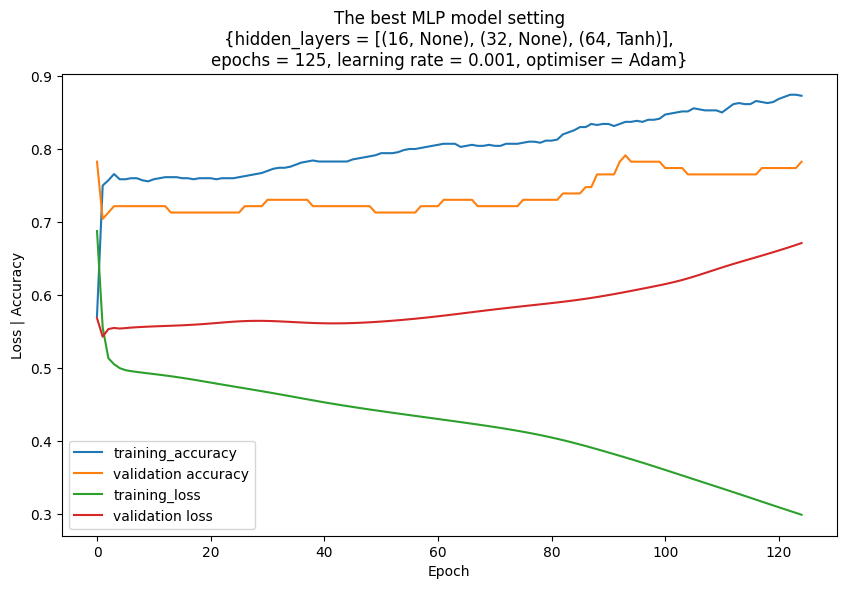

In [58]:
# Plotting the learning curve of the best MLP model
plt.figure(figsize = (10, 6))
plt.plot(my_mlp_model_training_log['epoch'], my_mlp_model_training_log['training_accuracy'], label = "training_accuracy")
plt.plot(my_mlp_model_training_log['epoch'], my_mlp_model_training_log['validation_accuracy'], label = "validation accuracy")
plt.plot(my_mlp_model_training_log['epoch'], my_mlp_model_training_log['training_loss'], label = "training_loss")
plt.plot(my_mlp_model_training_log['epoch'], my_mlp_model_training_log['validation_loss'], label = "validation loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss | Accuracy')
plt.title('The best MLP model setting\n{hidden_layers = [(16, None), (32, None), (64, Tanh)],\nepochs = 125, learning rate = 0.001, optimiser = Adam}')
plt.show()

# 5. Final evaluation of the chosen model setting on the testing data

In [59]:
from sklearn.metrics import recall_score, precision_score, f1_score, balanced_accuracy_score, confusion_matrix

def evaluate_model(model, test_input):
    """This function is just to condense some common metrics for the final 
    evaluation stage on the testing data after an optimal model has been chosen."""

    model.eval() # Set the model to evaluation mode
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in test_input:
            X = X.to(torch.float32)
            outputs = model(X)
            _, predicted_class = torch.max(outputs, 1)
            y_true.extend(np.array(y))
            y_pred.extend(np.array(predicted_class))

    condensed_evaluation = {}
    condensed_evaluation['recall'] = recall_score(y_true = y_true, y_pred = y_pred, pos_label = 1)
    condensed_evaluation['precision'] = precision_score(y_true = y_true, y_pred = y_pred, pos_label = 1)
    condensed_evaluation['f1_score'] = f1_score(y_true = y_true, y_pred = y_pred, pos_label = 1)
    condensed_evaluation['balanced_accuracy'] = balanced_accuracy_score(y_true = y_true, y_pred = y_pred)
    condensed_evaluation['confusion_matrix'] = confusion_matrix(y_true = y_true, y_pred = y_pred)

    return condensed_evaluation

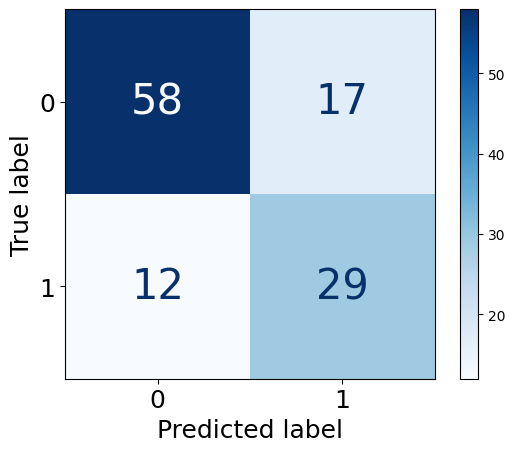

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay

# Displaying a confusion matrix on the testing data
diabetes_test_cf = evaluate_model(my_mlp_model, diabetes_test)['confusion_matrix']
diabetes_test_cf_disp = ConfusionMatrixDisplay(diabetes_test_cf)
diabetes_test_cf_disp.plot(cmap = plt.cm.Blues)
for labels in diabetes_test_cf_disp.text_.ravel():
    labels.set_fontsize(30)
plt.xlabel(xlabel = "Predicted label", fontdict = {'size': 18})
plt.ylabel(ylabel = "True label", fontdict = {'size': 18})
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

In [62]:
# Print out the test-evaluation results
evaluate_model(my_mlp_model, diabetes_test)

{'recall': 0.7073170731707317,
 'precision': 0.6304347826086957,
 'f1_score': 0.6666666666666667,
 'balanced_accuracy': 0.7403252032520324,
 'confusion_matrix': array([[58, 17],
        [12, 29]])}